### Import Necessary Packages

In [ ]:
import pandas as pd
import numpy as np

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
track_metadata_df = pd.read_csv('/content/gdrive/MyDrive/Kaazima/EchonestDataset/song_data.csv')
count_play_df =pd.read_csv('/content/gdrive/MyDrive/Kaazima/EchonestDataset/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

### Song_data.csv

In [ ]:
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())

Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Clearly, we have repeated track metadata.



### 10000.txt

In [ ]:
print('No of rows:', count_play_df.shape[0])
print('Number of unique users:', len(count_play_df.user.unique()))
display(count_play_df.head())

No of rows: 2000000
Number of unique users: 76353


,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


### Merge Datasets

Merge song_data.csv and 10000.txt based on the song_id.

In [ ]:
track_metadata_df.rename(columns = {'song_id': 'song'},inplace=True)
user_song_list_count = pd.merge(count_play_df, track_metadata_df.drop_duplicates(['song']), on='song', how ='left')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
display(user_song_list_count.head())

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


### Class for Item similarity based Recommender System model

In [ ]:
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None

    # Get unique items (songs) corresponding to a given user    
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items

    # Get unique users for a given item (song)    
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users

    # Get unique items (songs) in the training data    
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items

    #  Construct cooccurence matrix   
    def construct_cooccurence_matrix(self, user_songs, all_songs):

        #Get users for all songs in user_songs
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        #Initialize the item cooccurence matrix of size [len(user_songs) X len(all_songs)]
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #Calculate similarity between user songs and all unique songs in the training data
        for i in range(0,len(all_songs)):

            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:

                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        return cooccurence_matrix

    # Use the cooccurence matrix to make top recommendations    
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df

    # Create the item similarity based recommender system model        
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    # Use the item similarity based recommender system model to make recommendations    
    def recommend(self, user):
        
        #A. Get all unique songs for this user
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        #B. Get all unique items (songs) in the training data
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        #C. Construct item cooccurence matrix of size [len(user_songs) X len(songs)]
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #D. Use the cooccurence matrix to make recommendations
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations

    # Get similar items to given items    
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        #B. Get all unique items (songs) in the training data
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        #C. Construct item cooccurence matrix of size [len(user_songs) X len(songs)]
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #D. Use the cooccurence matrix to make recommendations
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations 

*Note: The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:*

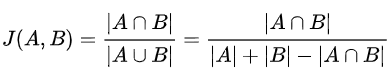

### Limit the items to the most popular 5000 songs

In [ ]:
total_play_count = sum(user_song_list_count.listen_count)
play_count = user_song_list_count[['song', 'listen_count']].groupby('song').sum().\
             sort_values(by='listen_count',ascending=False).head(5000)

print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

5,000 most popular songs represents 81.88% of total listen.


In [ ]:
song_subset = list(play_count.index[:5000])
user_subset = list(user_song_list_count.loc[user_song_list_count.song.isin(song_subset), 'user'].unique())
display('No of unique songs:', len(song_subset))
display('No of unique users', len(user_subset))
display('First 5 songs of song_subset:', song_subset[0:5])
display('First 5 users of user_subset:', user_subset[0:5])

'No of unique songs:'

5000

'No of unique users'

75708

'First 5 songs of song_subset:'

['SOBONKR12A58A7A7E0',
 'SOAUWYT12A81C206F1',
 'SOSXLTC12AF72A7F54',
 'SOEGIYH12A6D4FC0E3',
 'SOFRQTD12A81C233C0']

'First 5 users of user_subset:'

['b80344d063b5ccb3212f76538f3d9e43d87dca9e',
 '85c1f87fea955d09b4bec2e36aee110927aedf9a',
 'bd4c6e843f00bd476847fb75c47b4fb430a06856',
 '8937134734f869debcab8f23d77465b4caaa85df',
 '969cc6fb74e076a68e36a04409cb9d3765757508']

List the top 75 most popular songs

In [ ]:
display('First 75 songs of song_subset:', song_subset[0:75])

In [ ]:
user_song_list_count_sub = user_song_list_count[user_song_list_count.song.isin(song_subset)]
display(user_song_list_count_sub.head())

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


### Recommend songs for the user using personalized model

In [ ]:
is_model = item_similarity_recommender_py()
is_model.create(user_song_list_count_sub, 'user', 'title')
user_id = list(user_song_list_count_sub.user)[7]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 33
no. of unique songs in the training set: 4867
Non zero values in cooccurence_matrix :120655


,user_id,song,score,rank
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Quiet Houses,0.044710,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Meadowlarks,0.043836,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Heard Them Stirring,0.042740,3
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Tiger Mountain Peasant Song,0.041485,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Sun It Rises,0.040973,5
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Your Protector,0.039942,6
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Oliver James,0.039287,7
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Great Indoors,0.036765,8
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,White Winter Hymnal,0.036345,9
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,If I Could,0.034576,10


### Comparing the results with the top 2 songs played by the user

In [ ]:
display(user_song_list_count_sub[(user_song_list_count_sub.user==user_id) & (user_song_list_count_sub.listen_count>5)])

,user,song,listen_count,title,release,artist_name,year
16,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMGIYR12AB0187973,6,Behind The Sea [Live In Chicago],Live In Chicago,Panic At The Disco,0
43,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOYHEPA12A8C13097F,8,Moonshine,Thicker Than Water,Jack Johnson,2003


### We can also apply the model to find similar songs to any song in the dataset

In [ ]:
is_model.get_similar_items(['Moonshine'])

no. of unique songs in the training set: 4867
Non zero values in cooccurence_matrix :3835


,user_id,song,score,rank
0,,The Cove,0.311688,1
1,,Questions,0.184444,2
2,,Holes To Heaven,0.183357,3
3,,Supposed To Be,0.173719,4
4,,Wrong Turn,0.168750,5
5,,People Watching,0.166667,6
6,,The News,0.144986,7
7,,Posters,0.143271,8
8,,Belle,0.138989,9
9,,All At Once,0.138943,10
